In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt 
import datetime
from sklearn.metrics import fbeta_score

In [2]:
import lightgbm as lgb

In [3]:
class Config:
    pass
config = pd.read_pickle('config.pkl')
data_path = config.data_path
feature_path = config.feature_path
print dir(config)

['__doc__', '__module__', 'data_path', 'feature_dict', 'feature_path', 'result_path', 'single_module_validation_indice_set', 'trade_train_size']


In [4]:
trade_tt = pd.read_pickle(data_path+'trade_basic_and_recent_login.pkl')

In [5]:
trade_tt.columns

Index([u'month', u'day', u'weekday', u'hour', u'day_cycle', u'weekday_cycle',
       u'hour_cycle', u'timelong_login_0', u'timelong_login_1',
       u'timelong_login_2', u'log_from_login_0', u'log_from_login_1',
       u'log_from_login_2', u'city_login_0', u'city_login_1', u'city_login_2',
       u'result_login_0', u'result_login_1', u'result_login_2',
       u'type_login_0', u'type_login_1', u'type_login_2', u'is_scan_login_0',
       u'is_scan_login_1', u'is_scan_login_2', u'month_login_0',
       u'month_login_1', u'month_login_2', u'day_login_0', u'day_login_1',
       u'day_login_2', u'weekday_login_0', u'weekday_login_1',
       u'weekday_login_2', u'hour_login_0', u'hour_login_1', u'hour_login_2',
       u'day_cycle_login_0', u'day_cycle_login_1', u'day_cycle_login_2',
       u'weekday_cycle_login_0', u'weekday_cycle_login_1',
       u'weekday_cycle_login_2', u'hour_cycle_login_0', u'hour_cycle_login_1',
       u'hour_cycle_login_2', u'device_comparing_login_1',
       u'device_

In [6]:
del trade_tt['month_login_0']
del trade_tt['month_login_1']
del trade_tt['month_login_2']

In [7]:
trade_label = pd.read_pickle(data_path+'trade_train_label.pkl')
trade_train_val = trade_tt[trade_tt['month']<7]

In [8]:
del trade_train_val['month']

### Defining functions for validation

In [9]:
def f_beta_01(preds, train_data):
    labels  = train_data.get_label()
    return 'fbeta_score_01',fbeta_score(labels, preds > 0.5,0.1),True

    
#for binary
def runLGBM(train_X, train_y, test_X, test_y=None, feature_names=None,
           seed_val=0, num_rounds=10000,watch_dict = None,max_bin=50000,
           num_leaves=16,early_stop=64,verbose=True,eta=0.1,
           bagging_fraction = 0.75 , feature_fraction = 0.75,feval = None,metric = 'binary_logloss',
           train_sample_weight = None):
    
    params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'num_leaves': num_leaves,
        'learning_rate': eta,
        'feature_fraction': feature_fraction,
        'bagging_fraction': bagging_fraction,
        'bagging_freq': 5,
        'verbose': verbose,
        'is_unbalance':False
    }
    
    num_rounds = num_rounds

    #plst = list(param.items())
    lgbtrain = lgb.Dataset(train_X, label=train_y,max_bin=max_bin,feature_name=feature_names,weight =train_sample_weight)

    if test_y is not None:
        lgbtest = lgb.Dataset(test_X, label=test_y,max_bin=max_bin,feature_name=feature_names)
        watchlist = [lgbtrain,lgbtest]
        watchlist_name=['train','test']
        model = lgb.train(params, lgbtrain, num_rounds, watchlist,watchlist_name, early_stopping_rounds=early_stop,\
                         evals_result = watch_dict,verbose_eval=verbose,feval = feval)
    else:
        #lgbtest = lgb.Dataset(test_X,feature_name=feature_names)
        model = lgb.train(params, lgbtrain, num_rounds)

    pred_test_y = model.predict(test_X)
    return pred_test_y, model

config.f_beta = f_beta_01
config.LGBM = runLGBM

In [10]:
validation_tuple_list = config.single_module_validation_indice_set

### adding id By bear's request

In [13]:
trade_train = pd.read_csv(data_path+'t_trade.csv')

In [14]:
temp_trade_val = pd.DataFrame(trade_train_val)
temp_trade_val['id'] = trade_train['id']

In [16]:
#using all features
features = list(trade_train_val.columns)
cv_scores = []
cv_result = []
i = 0

for train_indice,val_indice in validation_tuple_list:
    #print trade_train_val.iloc[train_indice]['month'].unique(),trade_train_val.iloc[val_indice]['month'].unique()
    #print trade_train_val.iloc[train_indice].shape,trade_train_val.iloc[val_indice].shape
    result_dict = {}
    
    dev_set, val_set = temp_trade_val.iloc[train_indice,:] , temp_trade_val.iloc[val_indice,:] 
    #filter the features
    dev_X, val_X = dev_set[features].as_matrix(), val_set[features].as_matrix()
    dev_y, val_y = trade_label.iloc[train_indice].values, trade_label.iloc[val_indice].values

    
    preds, model = runLGBM(dev_X, dev_y, val_X, val_y,feature_names=features,verbose=100,eta=0.02,
                          early_stop=100,num_rounds=3500,watch_dict=result_dict,feval = None)

    #result_f_beta = f_beta_01(val_y.values, preds>0.5)
    result_f_beta  = fbeta_score( val_y,preds > 0.5, 0.1)
    
    cv_scores.append(result_f_beta)
    cv_result.append(result_dict)
    i+=1
    print'f_beta score for the turn '+str(i)+' is '+str(result_f_beta)

print 'The mean of the cv_scores is:'
print np.mean(cv_scores)

Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.924073	test's auc: 0.941208
[200]	train's auc: 0.971376	test's auc: 0.945075
[300]	train's auc: 0.985458	test's auc: 0.948961
[400]	train's auc: 0.991473	test's auc: 0.950296
Early stopping, best iteration is:
[395]	train's auc: 0.991265	test's auc: 0.950425
f_beta score for the turn 1 is 0.839009802293
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.936519	test's auc: 0.810354
[200]	train's auc: 0.967882	test's auc: 0.836138
[300]	train's auc: 0.985846	test's auc: 0.848953
[400]	train's auc: 0.994338	test's auc: 0.850113
[500]	train's auc: 0.997506	test's auc: 0.848031
Early stopping, best iteration is:
[423]	train's auc: 0.995581	test's auc: 0.852409
f_beta score for the turn 2 is 0.403327787022
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.940192	test's auc: 0.905573
[200]	train's auc: 0.974281	test's auc: 0.916882
[300]	train'

### Validation with f_beta

In [112]:
#using all features
features = list(trade_train_val.columns)
cv_scores = []
cv_result = []
i = 0

for train_indice,val_indice in validation_tuple_list:
    #print trade_train_val.iloc[train_indice]['month'].unique(),trade_train_val.iloc[val_indice]['month'].unique()
    #print trade_train_val.iloc[train_indice].shape,trade_train_val.iloc[val_indice].shape
    result_dict = {}
    
    dev_set, val_set = trade_train_val.iloc[train_indice,:] , trade_train_val.iloc[val_indice,:] 
    #filter the features
    dev_X, val_X = dev_set[features].as_matrix(), val_set[features].as_matrix()
    dev_y, val_y = trade_label.iloc[train_indice].values, trade_label.iloc[val_indice].values

    
    preds, model = runLGBM(dev_X, dev_y, val_X, val_y,feature_names=features,verbose=100,eta=0.02,
                          early_stop=100,num_rounds=3500,watch_dict=result_dict,feval = f_beta_01)

    #result_f_beta = f_beta_01(val_y.values, preds>0.5)
    result_f_beta  = fbeta_score( val_y,preds > 0.5, 0.1)
    
    cv_scores.append(result_f_beta)
    cv_result.append(result_dict)
    i+=1
    print'f_beta score for the turn '+str(i)+' is '+str(result_f_beta)

print 'The mean of the cv_scores is:'
print np.mean(cv_scores)

Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.928248	train's fbeta_score_01: 0.391588	test's auc: 0.937303	test's fbeta_score_01: 0.128926
[200]	train's auc: 0.971438	train's fbeta_score_01: 0.482688	test's auc: 0.944449	test's fbeta_score_01: 0.188673
[300]	train's auc: 0.984632	train's fbeta_score_01: 0.598789	test's auc: 0.947406	test's fbeta_score_01: 0.216195
[400]	train's auc: 0.991182	train's fbeta_score_01: 0.660241	test's auc: 0.950272	test's fbeta_score_01: 0.239151
Early stopping, best iteration is:
[371]	train's auc: 0.989696	train's fbeta_score_01: 0.639303	test's auc: 0.948855	test's fbeta_score_01: 0.252902
f_beta score for the turn 1 is 0.826759934514
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.937482	train's fbeta_score_01: 0.40978	test's auc: 0.813827	test's fbeta_score_01: 0.0576539
[200]	train's auc: 0.967438	train's fbeta_score_01: 0.476834	test's auc: 0.837802	test's fbeta_score_01: 0.09

###  Validation without f_beta

In [111]:
#using all features
features = list(trade_train_val.columns)
cv_scores = []
cv_result = []
i = 0

for train_indice,val_indice in validation_tuple_list:
    #print trade_train_val.iloc[train_indice]['month'].unique(),trade_train_val.iloc[val_indice]['month'].unique()
    #print trade_train_val.iloc[train_indice].shape,trade_train_val.iloc[val_indice].shape
    result_dict = {}
    
    dev_set, val_set = trade_train_val.iloc[train_indice,:] , trade_train_val.iloc[val_indice,:] 
    #filter the features
    dev_X, val_X = dev_set[features].as_matrix(), val_set[features].as_matrix()
    dev_y, val_y = trade_label.iloc[train_indice].values, trade_label.iloc[val_indice].values

    
    preds, model = runLGBM(dev_X, dev_y, val_X, val_y,feature_names=features,verbose=100,eta=0.02,
                          early_stop=100,num_rounds=3500,watch_dict=result_dict,feval = None)

    #result_f_beta = f_beta_01(val_y.values, preds>0.5)
    result_f_beta  = fbeta_score( val_y,preds > 0.5, 0.1)
    
    cv_scores.append(result_f_beta)
    cv_result.append(result_dict)
    i+=1
    print'f_beta score for the turn '+str(i)+' is '+str(result_f_beta)

print 'The mean of the cv_scores is:'
print np.mean(cv_scores)

Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.928248	test's auc: 0.937303
[200]	train's auc: 0.971438	test's auc: 0.944449
[300]	train's auc: 0.984632	test's auc: 0.947406
[400]	train's auc: 0.991182	test's auc: 0.950272
Early stopping, best iteration is:
[397]	train's auc: 0.991091	test's auc: 0.950372
f_beta score for the turn 1 is 0.833930518772
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.937482	test's auc: 0.813827
[200]	train's auc: 0.967438	test's auc: 0.837802
[300]	train's auc: 0.985526	test's auc: 0.8533
[400]	train's auc: 0.993768	test's auc: 0.85558
[500]	train's auc: 0.996887	test's auc: 0.854338
Early stopping, best iteration is:
[412]	train's auc: 0.994503	test's auc: 0.856286
f_beta score for the turn 2 is 0.432085561497
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.940939	test's auc: 0.905805
[200]	train's auc: 0.973318	test's auc: 0.917203
Early stopping,

### Picking up features by their gain importance

In [66]:
train_X = trade_train_val.as_matrix()
test_X =  trade_tt[trade_tt['month']>6].as_matrix() 
train_y = trade_label

In [113]:
#using binary logloss and auc and picking up the feature importance
preds, model = runLGBM(train_X, train_y, test_X, feature_names=features,verbose=100,eta=0.02,
                          early_stop=None,num_rounds=350,watch_dict=result_dict)

In [116]:
sorted_features = sorted(zip(features,model.feature_importance('gain')),key = lambda x : x[1],reverse = True)
pickup_feature_basic_comparing_detail =[x[0] for x in sorted_features[:len(sorted_features)/4*3]]
all_importance = [x[1] for x in sorted_features]

In [115]:
sorted_features

[('login_distance_0', 53360.023090910581),
 ('login_distance_1', 34923.374836857802),
 ('type_login_0', 19677.441689525629),
 ('login_distance_2', 17189.206321323349),
 ('hour_login_0', 16486.792560164427),
 ('device_comparing_login_1', 14709.854671406531),
 ('type_login_1', 12692.426649733794),
 ('timelong_login_0', 12510.633685847781),
 ('result_login_1', 9039.6209951457004),
 ('device_comparing_login_2', 8477.8499201496525),
 ('city_login_0', 7984.2215024065254),
 ('hour_login_2', 7582.7215749194738),
 ('hour_cycle_login_0', 6609.1007134229294),
 ('day_cycle_login_1', 6593.9375721544639),
 ('city_login_1', 6518.9973137301267),
 ('hour', 5885.8809720959871),
 ('result_login_2', 5728.2250223302099),
 ('type_login_2', 5418.1832968974622),
 ('timelong_login_2', 5159.1263669833534),
 ('hour_cycle_login_2', 5124.5753538053368),
 ('city_login_2', 4496.3821204959995),
 ('hour_cycle_login_1', 4448.4794468788405),
 ('hour_login_1', 3948.1032886730977),
 ('city_comparing_login_2', 3916.7407036

<Container object of 58 artists>

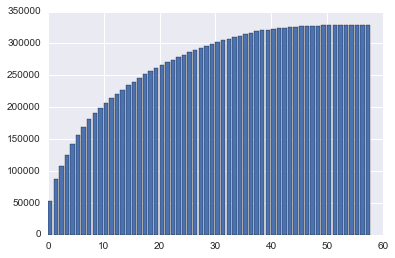

In [119]:
#显示从大到小的cumsum，看是否存在明显的8020
%matplotlib inline
x = pd.Series(all_importance).sort_values(ascending = False).cumsum()
plt.bar(range(len(x)),x)

In [121]:
#using all features
features = list(trade_train_val.columns)
cv_scores = []
cv_result = []
i = 0

for train_indice,val_indice in validation_tuple_list:
    #print trade_train_val.iloc[train_indice]['month'].unique(),trade_train_val.iloc[val_indice]['month'].unique()
    #print trade_train_val.iloc[train_indice].shape,trade_train_val.iloc[val_indice].shape
    result_dict = {}
    
    dev_set, val_set = trade_train_val.iloc[train_indice,:] , trade_train_val.iloc[val_indice,:] 
    #filter the features
    dev_X, val_X = dev_set[pickup_feature_basic_comparing_detail].as_matrix(), val_set[pickup_feature_basic_comparing_detail].as_matrix()
    dev_y, val_y = trade_label.iloc[train_indice].values, trade_label.iloc[val_indice].values

    
    preds, model = runLGBM(dev_X, dev_y, val_X, val_y,feature_names=pickup_feature_basic_comparing_detail,verbose=100,eta=0.02,
                          early_stop=100,num_rounds=3500,watch_dict=result_dict,feval = f_beta_01)

    #result_f_beta = f_beta_01(val_y.values, preds>0.5)
    result_f_beta  = fbeta_score( val_y,preds > 0.5, 0.1)
    
    cv_scores.append(result_f_beta)
    cv_result.append(result_dict)
    i+=1
    print'f_beta score for the turn '+str(i)+' is '+str(result_f_beta)

print 'The mean of the cv_scores is:'
print np.mean(cv_scores)

Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.926605	train's fbeta_score_01: 0.383189	test's auc: 0.935526	test's fbeta_score_01: 0.133531
Early stopping, best iteration is:
[1]	train's auc: 0.858088	train's fbeta_score_01: 0.311107	test's auc: 0.881576	test's fbeta_score_01: 0.33948
f_beta score for the turn 1 is 0.632371605043
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.934817	train's fbeta_score_01: 0.40441	test's auc: 0.801351	test's fbeta_score_01: 0.0576539
Early stopping, best iteration is:
[4]	train's auc: 0.880223	train's fbeta_score_01: 0.310267	test's auc: 0.750823	test's fbeta_score_01: 0.0768134
f_beta score for the turn 2 is 0.402992518703
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.941281	train's fbeta_score_01: 0.394359	test's auc: 0.904298	test's fbeta_score_01: 0.13685
[200]	train's auc: 0.973141	train's fbeta_score_01: 0.48185	test's auc: 0.916115	tes

### trying other threshold

In [124]:
def f_beta_01(preds, train_data):
    labels  = train_data.get_label()
    return 'fbeta_score_01',fbeta_score(preds > 0.3,labels,0.1),True

#using all features
features = list(trade_train_val.columns)
cv_scores = []
cv_result = []
i = 0

for train_indice,val_indice in validation_tuple_list:
    #print trade_train_val.iloc[train_indice]['month'].unique(),trade_train_val.iloc[val_indice]['month'].unique()
    #print trade_train_val.iloc[train_indice].shape,trade_train_val.iloc[val_indice].shape
    result_dict = {}
    
    dev_set, val_set = trade_train_val.iloc[train_indice,:] , trade_train_val.iloc[val_indice,:] 
    #filter the features
    dev_X, val_X = dev_set[features].as_matrix(), val_set[features].as_matrix()
    dev_y, val_y = trade_label.iloc[train_indice].values, trade_label.iloc[val_indice].values

    
    preds, model = runLGBM(dev_X, dev_y, val_X, val_y,feature_names=features,verbose=100,eta=0.02,
                          early_stop=100,num_rounds=3500,watch_dict=result_dict,feval = f_beta_01)

    #result_f_beta = f_beta_01(val_y.values, preds>0.5)
    result_f_beta  = fbeta_score( val_y,preds > 0.5, 0.1)
    
    cv_scores.append(result_f_beta)
    cv_result.append(result_dict)
    i+=1
    print'f_beta score for the turn '+str(i)+' is '+str(result_f_beta)

print 'The mean of the cv_scores is:'
print np.mean(cv_scores)

Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.928248	train's fbeta_score_01: 0.610514	test's auc: 0.937303	test's fbeta_score_01: 0.375942
Early stopping, best iteration is:
[26]	train's auc: 0.911035	train's fbeta_score_01: 0.829507	test's auc: 0.932783	test's fbeta_score_01: 0.852039
f_beta score for the turn 1 is 0.681619690353
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.937482	train's fbeta_score_01: 0.600583	test's auc: 0.813827	test's fbeta_score_01: 0.171996
Early stopping, best iteration is:
[26]	train's auc: 0.928659	train's fbeta_score_01: 0.845753	test's auc: 0.809007	test's fbeta_score_01: 0.631782
f_beta score for the turn 2 is 0.558011049724
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.940939	train's fbeta_score_01: 0.614923	test's auc: 0.905805	test's fbeta_score_01: 0.331758
Early stopping, best iteration is:
[1]	train's auc: 0.8362	train's fbeta_score_01

### adding the sample weighting for label ==1

In [136]:
#using all features
features = list(trade_train_val.columns)
cv_scores = []
cv_result = []
i = 0

for train_indice,val_indice in validation_tuple_list:
    #print trade_train_val.iloc[train_indice]['month'].unique(),trade_train_val.iloc[val_indice]['month'].unique()
    #print trade_train_val.iloc[train_indice].shape,trade_train_val.iloc[val_indice].shape
    result_dict = {}
    
    dev_set, val_set = trade_train_val.iloc[train_indice,:] , trade_train_val.iloc[val_indice,:] 
    #filter the features
    dev_X, val_X = dev_set[features].as_matrix(), val_set[features].as_matrix()
    dev_y, val_y = trade_label.iloc[train_indice].values, trade_label.iloc[val_indice].values
    
    dev_weight = np.array([10 if x==1 else 1 for x in dev_y])

    
    preds, model = runLGBM(dev_X, dev_y, val_X, val_y,feature_names=features,verbose=100,eta=0.02,
                          early_stop=100,num_rounds=3500,watch_dict=result_dict,feval = f_beta_01,train_sample_weight = dev_weight)

    #result_f_beta = f_beta_01(val_y.values, preds>0.5)
    result_f_beta  = fbeta_score( val_y,preds > 0.5, 0.1)
    
    cv_scores.append(result_f_beta)
    cv_result.append(result_dict)
    i+=1
    print'f_beta score for the turn '+str(i)+' is '+str(result_f_beta)

print 'The mean of the cv_scores is:'
print np.mean(cv_scores)

Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.96477	train's fbeta_score_01: 0.457801	test's auc: 0.944985	test's fbeta_score_01: 0.476088
[200]	train's auc: 0.981079	train's fbeta_score_01: 0.536524	test's auc: 0.947545	test's fbeta_score_01: 0.503081
[300]	train's auc: 0.988898	train's fbeta_score_01: 0.592707	test's auc: 0.949061	test's fbeta_score_01: 0.539238
[400]	train's auc: 0.993245	train's fbeta_score_01: 0.641571	test's auc: 0.949594	test's fbeta_score_01: 0.547165
Early stopping, best iteration is:
[392]	train's auc: 0.992896	train's fbeta_score_01: 0.639971	test's auc: 0.949888	test's fbeta_score_01: 0.549175
f_beta score for the turn 1 is 0.549175208494
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.963657	train's fbeta_score_01: 0.450018	test's auc: 0.843971	test's fbeta_score_01: 0.0912513
Early stopping, best iteration is:
[43]	train's auc: 0.952304	train's fbeta_score_01: 0.444658	test's auc: 0.

### Generate the best result without using f_beta

In [137]:
#finding the best iteration

def f_beta_01(preds, train_data):
    labels  = train_data.get_label()
    return 'fbeta_score_01',fbeta_score(labels, preds > 0.5,0.1),True

#using all features
features = list(trade_train_val.columns)
cv_scores = []
cv_result = []
i = 0

for train_indice,val_indice in validation_tuple_list:
    #print trade_train_val.iloc[train_indice]['month'].unique(),trade_train_val.iloc[val_indice]['month'].unique()
    #print trade_train_val.iloc[train_indice].shape,trade_train_val.iloc[val_indice].shape
    result_dict = {}
    
    dev_set, val_set = trade_train_val.iloc[train_indice,:] , trade_train_val.iloc[val_indice,:] 
    #filter the features
    dev_X, val_X = dev_set[features].as_matrix(), val_set[features].as_matrix()
    dev_y, val_y = trade_label.iloc[train_indice].values, trade_label.iloc[val_indice].values

    
    preds, model = runLGBM(dev_X, dev_y, val_X, val_y,feature_names=features,verbose=100,eta=0.02,
                          early_stop=None,num_rounds=400,watch_dict=result_dict,feval = f_beta_01)

    #result_f_beta = f_beta_01(val_y.values, preds>0.5)
    result_f_beta  = fbeta_score( val_y,preds > 0.5, 0.1)
    
    cv_scores.append(result_f_beta)
    cv_result.append(result_dict)
    i+=1
    print'f_beta score for the turn '+str(i)+' is '+str(result_f_beta)

print 'The mean of the cv_scores is:'
print np.mean(cv_scores)

[100]	train's auc: 0.928248	train's fbeta_score_01: 0.905333	test's auc: 0.937303	test's fbeta_score_01: 0.760419
[200]	train's auc: 0.971438	train's fbeta_score_01: 0.916142	test's auc: 0.944449	test's fbeta_score_01: 0.825065
[300]	train's auc: 0.984632	train's fbeta_score_01: 0.931017	test's auc: 0.947406	test's fbeta_score_01: 0.801994
[400]	train's auc: 0.991182	train's fbeta_score_01: 0.939739	test's auc: 0.950272	test's fbeta_score_01: 0.831144
f_beta score for the turn 1 is 0.831144168381
[100]	train's auc: 0.937482	train's fbeta_score_01: 0.915281	test's auc: 0.813827	test's fbeta_score_01: 0.502905
[200]	train's auc: 0.967438	train's fbeta_score_01: 0.91804	test's auc: 0.837802	test's fbeta_score_01: 0.47981
[300]	train's auc: 0.985526	train's fbeta_score_01: 0.921636	test's auc: 0.8533	test's fbeta_score_01: 0.410721
[400]	train's auc: 0.993768	train's fbeta_score_01: 0.93911	test's auc: 0.85558	test's fbeta_score_01: 0.410721
f_beta score for the turn 2 is 0.410720887246
[1

In [145]:
#finding the best iteration
pd_list = []
for dic in cv_result:
    pd_list.append(pd.DataFrame(dic['test']))
for i in range(len(pd_list)):
    pd_list[i].columns = pd_list[i].columns+'_'+str(i)

In [146]:
validation_result = pd.concat(pd_list,axis = 1)

In [151]:
validation_result['auc_avg'] = validation_result.apply(lambda x : np.mean([x.auc_0,x.auc_1,x.auc_2,x.auc_3,x.auc_4]),axis = 1)
validation_result['fbeta_avg'] = validation_result.apply(lambda x : np.mean([x.fbeta_score_01_0,x.fbeta_score_01_1,
                                                                     x.fbeta_score_01_2,x.fbeta_score_01_3,
                                                                     x.fbeta_score_01_4]),axis=1)

In [154]:
print validation_result['auc_avg'].idxmax()
print validation_result['fbeta_avg'].idxmax()

397
102


In [155]:
#generating the result using the best parameters
#using binary logloss and auc and picking up the feature importance
preds, _ = runLGBM(train_X, train_y, test_X, feature_names=features,verbose=100,eta=0.02,
                          early_stop=None,num_rounds=102,watch_dict=result_dict)

In [163]:
data_path

'../../kaggleData/JD_logging/'

In [164]:
result_path = '../../kaggleData/JD_logging/result/'
config.result_path = result_path

In [176]:
test_rowkey = pd.read_pickle(data_path+'trade_test_rowkey.pkl')
pred_label = pd.Series(preds > 0.5)
result_set = pd.DataFrame(test_rowkey)
result_set['is_risk'] = pred_label.astype(int)

print result_set.shape

(17875, 2)


In [179]:
pd.to_pickle(pred_label,result_path+'basic_detail_and_comparing.pkl')
result_set.to_csv(result_path+'basic_detail_and_comparing.csv',index=False,header=False)

In [166]:
dir(config)

['LGBM',
 '__doc__',
 '__module__',
 'data_path',
 'f_beta',
 'feature_dict',
 'feature_path',
 'result_path',
 'single_module_validation_indice_set',
 'trade_train_size']

In [167]:
del config.f_beta
del config.LGBM

In [168]:
pd.to_pickle(config,'config.pkl')